In [ ]:
from data import digs_data_loader
from data import utils as du
from data import se3_diffuser
from data import so3_diffuser
from data import r3_diffuser_vpsde
from analysis import plotting
from analysis import utils as au
from model import loss
from experiments import train_se3_diffusion
from openfold.utils import rigid_utils as ru
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from mpl_toolkits import mplot3d
from scipy.spatial.transform import Rotation

Rigid = ru.Rigid

from omegaconf import OmegaConf
import importlib
import os
import torch
import tree
import copy

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
importlib.reload(digs_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(du)
importlib.reload(plotting)
importlib.reload(loss)
importlib.reload(au)
importlib.reload(train_se3_diffusion)
importlib.reload(r3_diffuser_vpsde)

In [ ]:
base_conf_path = '../config/base.yaml'
base_conf = OmegaConf.load(base_conf_path)

# Load model checkpoint
# ckpt_dir = '../pkl_jar/ckpt/sanity_check_1_20D_08M_2022Y_06h_23m_25s/'
# ckpt_dir = '../pkl_jar/ckpt/sanity_check_1_rescale_20D_08M_2022Y_08h_40m_20s'
ckpt_dir = '../pkl_jar/ckpt/sanity_check_no_crop_20D_08M_2022Y_11h_04m_15s'
# ckpt_dir = '../pkl_jar/ckpt/mini_subset_len_50_20D_08M_2022Y_12h_11m_52s'

# ckpt_dir = '../pkl_jar/ckpt/mini_subset_20D_08M_2022Y_12h_40m_22s'
# ckpt_dir = '../pkl_jar/ckpt/mini_subset_20D_08M_2022Y_13h_04m_15s'

# ckpt_dir = '../pkl_jar/ckpt/subset_100_20D_08M_2022Y_18h_43m_20s'


if len(os.listdir(ckpt_dir)) != 1:
    raise ValueError(f'Ambiguous ckpt in {ckpt_dir}')
ckpt_path = os.path.join(
    ckpt_dir, os.listdir(ckpt_dir)[0])
ckpt_pkl = du.read_pkl(ckpt_path)
ckpt_conf = ckpt_pkl['conf']
ckpt_model = ckpt_pkl['model']

conf = OmegaConf.merge(base_conf, ckpt_conf)
conf.data.digs.cache_dir = '../pkl_jar/'

print(ckpt_path)
# print(OmegaConf.to_yaml(ckpt_conf))

In [ ]:
# Initialize model class
exp = train_se3_diffusion.Experiment(conf=conf)
exp.model.load_state_dict(ckpt_model)
exp.model.to(device)
exp_diffuser = exp.diffuser
train_loader, _, valid_loader, _ = exp.create_digs_dataset(0, 1)
exp_diffuser
= exp.diffuser

In [ ]:
# Sample data point to initializez.
data_iter = iter(train_loader)
raw_data_feats = next(data_iter)

In [ ]:
# Preprocess init data
batch_idx = 0
data_feats = tree.map_structure(lambda x: x[batch_idx], raw_data_feats)
res_mask = data_feats['res_mask']
res_idx = data_feats['res_idx']
rigids_0 = data_feats['rigids_0']

rigids_0 = rigids_0[torch.where(res_mask.bool())]
res_mask = res_mask[torch.where(res_mask.bool())]

num_res = res_mask.shape[0]
rigids_init = exp_diffuser.random_init(num_res).to_tensor_7()
rigids_init *= res_mask[:, None]
init_feats = {
    'rigids_t': rigids_init[torch.where(res_mask.bool())],
    'res_mask': res_mask,
    'res_idx': res_idx[torch.where(res_mask.bool())],
    't': torch.tensor(exp_diffuser.num_t),
}
rigids_0 = rigids_0[torch.where(res_mask.bool())]
res_mask = res_mask[torch.where(res_mask.bool())]

num_res = res_mask.shape[0]


# init_feats = {
#     'rigids_t': rigids_init,
#     'res_mask': res_mask,
#     'res_idx': res_idx,
#     't': torch.tensor(exp_diffuser.num_t),
# }
init_feats = tree.map_structure(lambda x: x[None].to(device), init_feats)
print(f'Sample length {torch.sum(res_mask)}')

In [ ]:
rand_rot = torch.Tensor(Rotation.random().as_matrix())
rigids_init = exp_diffuser.random_init(num_res, apply_rot=rand_rot).to_tensor_7()
rigids_init *= res_mask[:, None]
init_feats = {
    'rigids_t': rigids_init[torch.where(res_mask.bool())],
    'res_mask': res_mask,
    'res_idx': res_idx[torch.where(res_mask.bool())],
    't': torch.tensor(exp_diffuser.num_t),
}
init_feats = tree.map_structure(lambda x: x[None].to(device), init_feats)
print(f'Sample length {torch.sum(res_mask)}')

In [ ]:
# # rand_rot = torch.Tensor(Rotation.random().as_matrix())
# # rand_rot = torch.Tensor(Rotation.from_euler('z', 180, degrees=True).as_matrix())
# rand_rot = torch.Tensor(Rotation.from_euler('z', 90, degrees=True).as_matrix())
# rigids_init = exp_diffuser.random_init(num_res).to_tensor_7()
# rigids_init *= res_mask[:, None]
# init_feats = {
#     'rigids_t': rigids_init[torch.where(res_mask.bool())],
#     'res_mask': res_mask,
#     'res_idx': res_idx[torch.where(res_mask.bool())],
#     't': torch.tensor(exp_diffuser.num_t),
# }
# init_feats = tree.map_structure(lambda x: x[None].to(device), init_feats)
# print(f'Sample length {torch.sum(res_mask)}')

In [ ]:
# frame_init = ru.Rigid.from_tensor_7(rigids_init[res_mask.bool()])
# frame_gt = ru.Rigid.from_tensor_7(rigids_0[res_mask.bool()])
# print(frame_init.get_rots().get_rot_mats()[:3])
# print(frame_init.get_trans()[:3])
# print(frame_gt.get_rots().get_rot_mats()[:3])

In [ ]:
exp.diffuser._diffuse_rots = False

In [ ]:
# Run inference
sample_steps = exp.inference_fn(init_feats, add_noise=False)

In [ ]:
# Plot out SE(3)
final_rigid = sample_steps[-1][0]
f, axes = plt.subplots(1, 3, figsize=[24, 8], subplot_kw=dict(projection="3d"))
scale_factor = conf.data.digs.scale_factor
ax_lim = 15.
plotting.viz_frames(init_feats['rigids_t'][0], res_mask, axes[0], title='Initialization', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(final_rigid, res_mask, axes[1], title='Sample', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(rigids_0, res_mask, axes[2], title='Ground truth', scale_factor=scale_factor, ax_lim=ax_lim)

In [162]:
# Calculate FAPE and Ca-RMSD metrics.
fape_loss = loss.rigids_fape(final_rigid, rigids_0.to(final_rigid.device), res_mask.to(final_rigid.device), length_scale=scale_factor)
rmsd_loss, aligned_pred_ca, gt_ca, align_rot_mat, align_trans, reflection = loss.rigids_ca_rmsd(final_rigid, rigids_0.to(final_rigid.device), res_mask.to(final_rigid.device), length_scale=scale_factor, return_align=True)
align_rot_euler = Rotation.from_matrix(align_rot_mat).as_euler('xyz', degrees=True)
print(f'FAPE: {fape_loss:2.4f}\nCa-RMSD: {rmsd_loss:2.4f}')
print(f'Alignment rotation: {align_rot_euler}\nAlignment translation: {align_trans[:,0]}\nAlignment reflection: {reflection}')


FAPE: 0.2245
Ca-RMSD: 8.2044
Alignment rotation: [ 0.6813186  -2.14084253 17.88014551]
Alignment translation: [-4.5645024e-08  1.5047092e-07  9.2828614e-08]
Alignment reflection: False


In [ ]:
# Visualize aligned Ca structures
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

plotting.plt_3d(aligned_pred_ca, ax, color='r', s=100, mode='scatter')
plotting.plt_3d(aligned_pred_ca, ax, color='r', mode='line')
plotting.plt_3d(gt_ca, ax, color='b', s=100, mode='scatter')
plotting.plt_3d(gt_ca, ax, color='b', mode='line')

In [88]:
sample_traj = torch.stack(sample_steps)[:, 0]

INFO: Animation.save using <class 'matplotlib.animation.PillowWriter'>


Saved gif to: dev_diffusion_1.gif


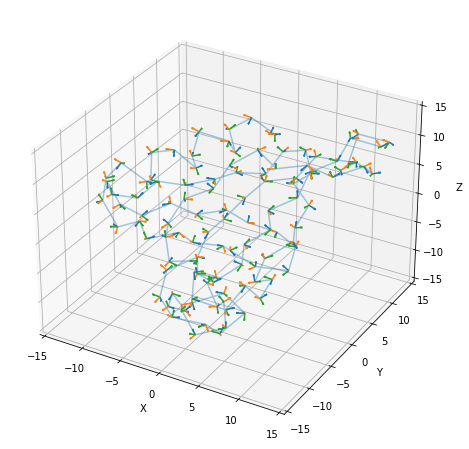

In [89]:
ax_lim = 15

fig, ax = plt.subplots(1, 1, figsize=[8, 8], subplot_kw=dict(projection="3d"))
bb_mask = du.move_to_np(res_mask).astype(bool)

def extract_se3_vec(step, scale_factor=10.0):
    frame = sample_traj[step]
    frame = frame[bb_mask]
    se3_vec = au.rigids_to_se3_vec(du.move_to_np(frame), scale_factor=scale_factor)
    return se3_vec


_ = plotting.plot_se3(extract_se3_vec(0), ax=ax, ax_lim=ax_lim)

def update(frame):
    ax.clear()
    plotting.plot_se3(extract_se3_vec(frame), ax=ax, ax_lim=ax_lim)

anim = FuncAnimation(
    fig,
    update,
    frames=list(range(1, exp.diffuser.num_t)),
    interval=10,
    blit=False)
writergif = animation.PillowWriter(fps=30) 
# f = f'/data/rsg/chemistry/jyim/protein_diffusion_samples/se3_diffusion/dev_diffusion_{b_idx}.gif'
f = f'dev_diffusion_1.gif'
anim.save(f, writer=writergif)
print(f'Saved gif to: {f}')

KeyError: 'bb_mask'

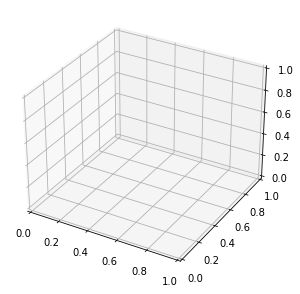

In [54]:
create_animation(0, sample_steps, torch.ones_like(res_mask), data_feats)

In [52]:
# TODO: Incorporate animations
def create_animation(b_idx, all_sampled_frames, sample_mask, data_raw):
    ax_lim = 10

    fig, ax = plt.subplots(1, 1, figsize=[5, 5], subplot_kw=dict(projection="3d"))
    bb_mask = du.move_to_np(data_raw['res_mask']).astype(bool)

    def extract_se3_vec(step, b_idx, scale_factor=10.0):
        frame = all_sampled_frames[step] * sample_mask[..., None] + data_raw['rigids_0'] * (1 - sample_mask[..., None])
        frame = frame[b_idx][bb_mask[b_idx]]
        se3_vec = au.rigids_to_se3_vec(du.move_to_np(frame), scale_factor=scale_factor)
        return se3_vec


    _ = plotting.plot_se3(extract_se3_vec(0, b_idx), ax=ax, ax_lim=ax_lim)

    def update(frame):
        ax.clear()
        plotting.plot_se3(extract_se3_vec(frame, b_idx), ax=ax, ax_lim=ax_lim)

    anim = FuncAnimation(
        fig,
        update,
        frames=list(range(1, exp.diffuser.num_steps)),
        interval=10,
        blit=False)
    writergif = animation.PillowWriter(fps=30) 
    # f = f'/data/rsg/chemistry/jyim/protein_diffusion_samples/se3_diffusion/dev_diffusion_{b_idx}.gif'
    f = f'dev_diffusion_{b_idx}.gif'
    anim.save(f, writer=writergif)
    print(f'Saved gif to: {f}')